# Dogs vs. Cats

En este mini proyecto haremos una CNN muy sencilla para clasificar entre perros y gatos, sin embargo, la principal diferencia respecto a todos los otros ejemplos es que en esta ocasión NO partiremos de un dataset de Keras, sino que tendremos a nuestra disposición un dataset.

[cnn_data_sources](https://www.kaggle.com/datasets/alarcon7a/cnn-data-sources?select=cats_and_dogs)

El dataset contiene la siguiente distribución de datos:

- Train: 2000 imágenes, 1000 gatos - 1000 perros

- Test: 1000 imágenes, 500 gatos - 500 perros

- Validation: 1000 imágenes, 500 gatos - 500 perros

El nombre de las carpetas indica explícitamente en nombre de la etiqueta a la que pertenece la imagen. Sin embargo, cada imagen puede tener dimensiones diferentes, y estas no están normalizadas de ninguna manera. Nuestro trabajo será entonces convertir esta carpeta en un dataset de entrenamiento, validación y prueba para nuestra CNN. Para ello usaremos el método `datagen.flow_from_directory` del cual hablamos brevemente en Aplicando data augmentation, pero en este ejemplo lo usaremos concretamente.


## 1: Importando bibliotecas


In [3]:
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

## 2: Definamos una arquitectura sencilla

Para este ejemplo, no nos centraremos en crear un modelo óptimo, sino en mostrar el flujo de información y como generar el dataset desde las imágenes de entrada distribuidas en diferentes carpetas.


In [5]:
def architecture(n_filters, input_shape):
    model = Sequential()

    model.add(
        Conv2D(
            filters=n_filters,
            kernel_size=(3, 3),
            activation="relu",
            input_shape=input_shape,
        )
    )
    model.add(MaxPooling2D(2, 2))

    model.add(Conv2D(filters=n_filters * 2, kernel_size=(3, 3), activation="relu"))
    model.add(MaxPooling2D(2, 2))

    model.add(Conv2D(filters=n_filters * 4, kernel_size=(3, 3), activation="relu"))
    model.add(MaxPooling2D(2, 2))

    model.add(Conv2D(filters=n_filters * 4, kernel_size=(3, 3), activation="relu"))
    model.add(MaxPooling2D(2, 2))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.summary()

    return model

## 3: Creación de Image Data Generators

Para este particular problema usaremos `Image Data Generators` porque tenemos muy pocos datos de entrenamiento para nuestro problema, apenas contamos con `2,000` ejemplos `1,000` de cada clase.

Para el generador de entrenamiento tendremos la siguiente configuración:


In [6]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
)

Como podemos observar, podemos permitir varias alteraciones a las imágenes originales. Pero el primer punto de rescale es que va a dividir toda la imagen entre 255, una normalización básica pero bastante útil.

Para el generador de test lo único que haremos será utilizar él `rescale` para normalizar los datos, pero este objeto no será útil más adelante para cargar las imágenes de validation y test.


In [7]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

## 4: Definimos el batch_size con el cual van a trabajar los generadores de imágenes

Este valor también será utilizado más adelante para definir steps_per_epoch y validation_steps


In [8]:
bs = 32

## 5: Creando los datasets de entrenamiento, validación y pruebas

Como podemos apreciar, nuestra data de entrenamiento éxiste en el `train_generator` que a su vez se crea por el objeto `train_datage` que definimos anteriormente, adicionalmente, usamos el método `flow_from_directory` para decirle que las imáquenes que va a aumentar provienen del directorio `data/train`, adicionalmente, le pedimos que re-escale todas las imágenes a una resolución de **(150x150) píxeles**, y que ocupe el `batch_size` que definimos anteriormente como `bs`, finalmente, este directorio solo cuenta con **2 clases**, es por ello que elegimos `class_mode` como **binary**.


In [9]:
train_generator = train_datagen.flow_from_directory(
    directory="../data/cats_and_dogs/train",
    target_size=(150, 150),
    batch_size=bs,
    class_mode="binary",
)

validation_generator = test_datagen.flow_from_directory(
    directory="../data/cats_and_dogs/validation",
    target_size=(150, 150),
    batch_size=bs,
    class_mode="binary",
)

test_generator = test_datagen.flow_from_directory(
    directory="../data/cats_and_dogs/test",
    target_size=(150, 150),
    batch_size=bs,
    class_mode="binary",
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Finalmente, podemos observar como los datasets de `validation` y `test` no tienen ninguna transformación a los datos más que la normalización de dividir entre 255.


# Entrenamiento del modelo de clasificación de perros y gatos


Antes de entrenar el modelo, es buena idea crear un callback de tipo checkpoint para siempre tener guardado el `best_model`


In [10]:
checkpoint_cb = ModelCheckpoint(
    "../model/cats_vs_dogs.keras", verbose=1, save_best_only=True, monitor="val_acc"
)

## 6: Creando y compilando el modelo


In [11]:
md = architecture(n_filters=32, input_shape=(150, 150, 3))
md.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["acc"])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)      

## 7: Entrenamos el modelo


In [13]:
history = md.fit(
    train_generator,
    epochs=30,
    steps_per_epoch=2000 // bs,
    validation_data=validation_generator,
    validation_steps=1000 // bs,
    callbacks=[checkpoint_cb],
    batch_size=64,
)

Epoch 1/30


62/62 [==============================] - ETA: 0s - loss: 0.7048 - acc: 0.5203
Epoch 1: val_acc improved from -inf to 0.50202, saving model to ../model\cats_vs_dogs.keras
62/62 [==============================] - 25s 393ms/step - loss: 0.7048 - acc: 0.5203 - val_loss: 0.6908 - val_acc: 0.5020
Epoch 2/30
62/62 [==============================] - ETA: 0s - loss: 0.6921 - acc: 0.5213
Epoch 2: val_acc improved from 0.50202 to 0.57560, saving model to ../model\cats_vs_dogs.keras
62/62 [==============================] - 15s 237ms/step - loss: 0.6921 - acc: 0.5213 - val_loss: 0.6861 - val_acc: 0.5756
Epoch 3/30
62/62 [==============================] - ETA: 0s - loss: 0.6930 - acc: 0.5203
Epoch 3: val_acc improved from 0.57560 to 0.57863, saving model to ../model\cats_vs_dogs.keras
62/62 [==============================] - 15s 247ms/step - loss: 0.6930 - acc: 0.5203 - val_loss: 0.6776 - val_acc: 0.5786
Epoch 4/30
62/62 [==============================] - ETA: 0s - loss: 0.6816 - acc: 0

## 8: Análisis de resultados


In [16]:
def plot_result(history_, metric):
    history_dict = history_.history
    loss_values = history_dict["loss"]
    val_loss_values = history_dict["val_loss"]
    metric_values = history_dict[metric]
    val_metric_values = history_dict[f"val_{metric}"]
    epoch = range(1, len(loss_values) + 1)

    fig, ax = plt.subplots(1, 2, figsize=(8, 5))

    fig.suptitle(f"Neural Network's Result")
    ax[0].set_title("Loss function over epochs")
    ax[0].set(ylabel="Loss", xlabel="Epochs")
    ax[0].plot(epoch, loss_values, "o-r", label="Training")
    ax[0].plot(epoch, val_loss_values, "--", label="Validation")
    ax[0].legend()

    ax[1].set_title(f"{metric} over epochs")
    ax[1].set(ylabel=metric, xlabel="Epochs")
    ax[1].plot(epoch, metric_values, "o-r", label="Training")
    ax[1].plot(epoch, val_metric_values, "--", label="Validation")
    ax[1].legend()

    plt.show()

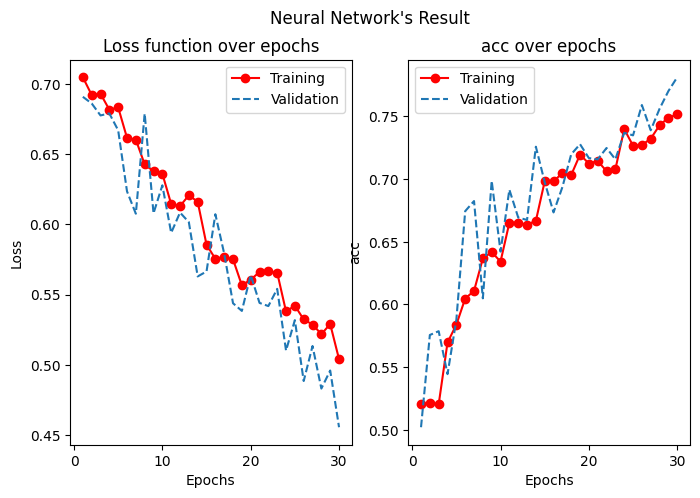

In [18]:
plot_result(history, "acc")

In [19]:
best_model = load_model("../model/cats_vs_dogs.keras")

acc = best_model.evaluate(test_generator)

print(acc)

32/32 [==============================] - 5s 142ms/step - loss: 0.5222 - acc: 0.7390
[0.5221590399742126, 0.7390000224113464]


# Conclusiones:

Podemos observar como con muy pocas líneas de código y poca optimización y teniendo un modelo simple e intuitivo hemos logrado obtener aproximadamente un 80% de precisión al momento de clasificar entre perros y gatos. Sin embargo, nuestras gráficas de resultados muestran un ligero overfitting, el cual podríamos mejorar con algunas técnicas de normalización que ya hemos visto a lo largo del curso.

Este pequeño proyecto nos ha permitido tener el conocimiento de como entrenar a nuestros modelos de CNNs directamente desde datasets de imágenes obtenidas y clasificadas directamente por nosotros, esto nos brida mucha libertad, puesto que en problemas anteriores siempre habíamos utilizado datasets ya existentes de keras, los cuales ya estaban relativamente limpios y listos para su uso.
